# DL CNN project

In [2]:
import os
import cv2
import copy
import math
import random as rand
import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Lambda, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback

from PIL import Image

from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix

from google.colab import files
import uuid
import matplotlib.pyplot as plt

## Set up the Kaggle API

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


## Download the dataset

In [4]:
!kaggle datasets download "lakshaymiddha/crack-segmentation-dataset"
!unzip -q crack-segmentation-dataset.zip
!rm crack-segmentation-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset
License(s): unknown
 99% 1.96G/1.98G [00:10<00:00, 236MB/s]
100% 1.98G/1.98G [00:10<00:00, 211MB/s]
replace crack_segmentation_dataset/images/CFD_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace crack_segmentation_dataset/images/CFD_002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Dataset

In [5]:
# Paths
TRAIN_IMG_DIR = 'crack_segmentation_dataset/train/images'
TRAIN_MASK_DIR = 'crack_segmentation_dataset/train/masks'
TEST_IMG_DIR = 'crack_segmentation_dataset/test/images'
TEST_MASK_DIR = 'crack_segmentation_dataset/test/masks'

# Dataset Instance
class CrackSegmentationDatasetInstance:
    def __init__(self, filename, test=False):
        self.img_path = os.path.join(
            TEST_IMG_DIR if test else TRAIN_IMG_DIR, filename
        )
        self.is_crack = not filename.startswith('noncrack')
        self.mask_path = os.path.join(
            TEST_MASK_DIR if test else TRAIN_MASK_DIR, filename
        )

    def get_img(self):
        img = cv2.imread(self.img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img / 255.0  # Normalize to [0, 1]
    def set_img(self,img):
        self.img = img

    def get_label(self):
        return int(self.is_crack)  # Binary label: 0 or 1

    def get_mask(self):
        mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE)
        mask =  mask / 255.0  # Normalize mask to [0, 1]
        return np.expand_dims(mask, axis=-1)

# Main Dataset
class CrackSegmentationDataset:
    def __init__(self):
        self.train_instances = [
            CrackSegmentationDatasetInstance(filename)
            for filename in os.listdir(TRAIN_IMG_DIR)
        ]
        self.test_instances = [
            CrackSegmentationDatasetInstance(filename, test=True)
            for filename in os.listdir(TEST_IMG_DIR)
        ]

    def _generator(self, instances, task='classification'):
        for instance in instances:
            img = instance.get_img()
            if task == 'classification':
                yield img, instance.get_label()
            elif task == 'segmentation':
                yield img, instance.get_mask()

    def get_dataset(self, split='train', batch_size=32, task='classification', stratified=False):
        # Select instances based on the split
        instances = (
            self.train_instances if split == 'train' else self.test_instances
        )

        output_types = (tf.float32, tf.int32 if task == 'classification' else tf.float32)
        output_shapes = (
            tf.TensorShape([448, 448, 3]),
            tf.TensorShape([]) if task == 'classification' else tf.TensorShape([448, 448, 1]),
        )

        # If split is 'test', only return the test dataset
        if split == 'test':
            dataset = tf.data.Dataset.from_generator(
                lambda: self._generator(instances, task),
                output_types=output_types,
                output_shapes=output_shapes
            )
            dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
            return dataset, None

        # Handle stratified sampling if enabled
        if stratified:
            crack_instances = [instance for instance in instances if instance.get_label() == 1]
            non_crack_instances = [instance for instance in instances if instance.get_label() == 0]

            # Split crack and non-crack instances into train and validation sets
            crack_train = crack_instances[:int(0.8 * len(crack_instances))]
            crack_val = crack_instances[int(0.8 * len(crack_instances)):]
            non_crack_train = non_crack_instances[:int(0.8 * len(non_crack_instances))]
            non_crack_val = non_crack_instances[int(0.8 * len(non_crack_instances)):]

            train_instances = crack_train + non_crack_train
            val_instances = crack_val + non_crack_val

            # Shuffle the instances for randomness
            rand.shuffle(train_instances)
            rand.shuffle(val_instances)
        else:
            # Random shuffle and split instances into train and validation sets
            rand.shuffle(instances)
            train_size = int(0.8 * len(instances))
            train_instances = instances[:train_size]
            val_instances = instances[train_size:]

        # Create train and validation datasets
        train_ds = tf.data.Dataset.from_generator(
            lambda: self._generator(train_instances, task),
            output_types=output_types,
            output_shapes=output_shapes
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        val_ds = tf.data.Dataset.from_generator(
            lambda: self._generator(val_instances, task),
            output_types=output_types,
            output_shapes=output_shapes
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        return train_ds, val_ds

    def augment(self, augmentation_dir='crack_segmentation_dataset/train/images'):
        '''Augment the dataset by applying fixed-angle rotation, cropping a random square region,
        and rescaling to the original dimensions.'''

        instances_crack = [instance for instance in self.train_instances if instance.get_label() == 1]
        instances_non_crack = [instance for instance in self.train_instances if instance.get_label() == 0]
        diff_instances = len(instances_crack) - len(instances_non_crack)

        for _ in range(diff_instances):
            rand_instance = rand.choice(instances_non_crack)
            new_img = rand_instance.get_img()

            height, width = new_img.shape[:2]

            # Random rotation
            fixed_angles = [90, 180, 270, -90, -180, -270]
            random_angle = rand.choice(fixed_angles)
            center = (width / 2, height / 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, random_angle, scale=1.0)
            rotated_img = cv2.warpAffine(new_img, rotation_matrix, (width, height))

            # Random cropping
            crop_width = int(width * rand.uniform(0.8, 1))
            crop_height = crop_width
            x_start = rand.randint(0, width - crop_width)
            y_start = rand.randint(0, height - crop_height)
            cropped_img = rotated_img[y_start:y_start + crop_height, x_start:x_start + crop_width]

            # Resize back to original
            resized_img = cv2.resize(cropped_img, (width, height), interpolation=cv2.INTER_LINEAR)

            # Save augmented image
            filename = os.path.join(augmentation_dir, f"noncrack_{uuid.uuid4()}.jpg")
            cv2.imwrite(filename, (resized_img * 255).astype('uint8'))

            # Add the new instance
            new_instance = CrackSegmentationDatasetInstance(filename, test=False)
            self.train_instances.append(new_instance)

        rand.shuffle(self.train_instances)

### Dataset creation

In [6]:
dataset = CrackSegmentationDataset()

## Dataset analysis

In [ ]:
counter = Counter(instance.get_label() for instance in dataset.train_instances)

print(f"Number of non-crack images: {counter[0]}")
print(f"Number of crack images: {counter[1]}")

Number of non-crack images: 1199
Number of crack images: 8404


## Basic classification

Here we created a very simple model, with convolution, pooling and dense layer with relu activation function, as we expected the basic task shall not be too sophisticated and such light network could deal with it.
To trace the performance of our model while training, and to be able to use all kind of earlystopping, leave-plateau methods, we further splitted the test set into test set and validation set. in proportion 4/1

In [9]:
# Binary classification dataset

epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')
test_ds, _ = dataset.get_dataset(split='test', batch_size=32, task='classification')

# Build simple binary classification model
classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),  # Define fixed input shape
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    # tf.keras.layers.Dense(2, activation='softmax')
])

classification_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train classification model
classification_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
    204/Unknown 51s 221ms/step - accuracy: 0.8590 - loss: 7.7557

KeyboardInterrupt: 

#### Evaluation on the test set

In [10]:
# Evaluate the model on the test dataset
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step - accuracy: 0.8910 - loss: 0.6267
Test Loss: 0.6296
Test Accuracy: 0.8749


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.00      0.00      0.00       212
       Crack       0.87      1.00      0.93      1483

    accuracy                           0.87      1695
   macro avg       0.44      0.50      0.47      1695
weighted avg       0.77      0.87      0.82      1695

Confusion Matrix:
[[   0  212]
 [   0 1483]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Imbalanced data
As we have discovered earlier the data set is highly imbalanced with 8 times more crack images than non crack images in the training set. In the previous example we saw how it affected the model perfromance, it was  biased towards predicting crack and was basically as good as just saying crack without seeing the image. To address this issue, we devised several methods
- first approach is to use a specifically tailored loss function for the imbalanced data. In this case we can explore a variation of the binary cross-entropy a binary focal crossentropy. this variation of crossentropy that accounts for 'difficulty' of examples . Since due to imbalance in training data, the non-crack examples are far more difficult to properly classify, this loss function is paying more attention to misclassified examples = non-crack examples, it is a boosting approach.
- second  approach, we can augment the non-crack images eg artificialy create more of the examples of this class. to do so we can freely rotate them by some multiplicity of 90 degrees(to avoid having padding) and zoom, it shall produce completly valid non-crack images

### weighted cross-entropy

As mentioned earlier: to leverage all of the data, but without the need of augmentation but still addressing the issue of the  data imbalance we can adjust our loss function to a tweaked version of binary cross entropy. This version will use  boosting on the non-crack  examples, as it accounts for the class imbalance in the training ( non crack being more difficult to classify trerefore mistkae on them is penalized more in this loss function)







In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds,val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')

# Build simple binary classification model
classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),  # Define fixed input shape
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)

# as there is approximately 8 times less of the non-crack data

# Train classification model
classification_model.fit(
    train_ds,
    validation_data=val_ds,  # Pass validation data here
    epochs=10,
    callbacks=[epoch_early_stopping],  # Use epoch-wise early stopping
     # Use batch-wise early stopping callback
    verbose=1  # Print logs
)

Epoch 1/10
    241/Unknown 56s 216ms/step - accuracy: 0.7983 - loss: 4.9419

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


241/241 ━━━━━━━━━━━━━━━━━━━━ 71s 281ms/step - accuracy: 0.7985 - loss: 4.9266 - val_accuracy: 0.9183 - val_loss: 0.0701
Epoch 2/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 73s 304ms/step - accuracy: 0.9370 - loss: 0.0542 - val_accuracy: 0.9328 - val_loss: 0.0548
Epoch 3/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 85s 315ms/step - accuracy: 0.9427 - loss: 0.0446 - val_accuracy: 0.9131 - val_loss: 0.0845
Epoch 4/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 73s 280ms/step - accuracy: 0.9553 - loss: 0.0337 - val_accuracy: 0.9521 - val_loss: 0.0559
Epoch 5/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 68s 282ms/step - accuracy: 0.9619 - loss: 0.0333 - val_accuracy: 0.9500 - val_loss: 0.0609
Epoch 6/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 63s 262ms/step - accuracy: 0.9703 - loss: 0.0266 - val_accuracy: 0.9167 - val_loss: 0.1120
Epoch 7/10
241/241 ━━━━━━━━━━━━━━━━━━━━ 64s 267ms/step - accuracy: 0.9685 - loss: 0.0220 - val_accuracy: 0.9490 - val_loss: 0.0792


In [ ]:
# Evaluate the model on the test dataset
test_ds, _ = dataset.get_test_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.9409 - loss: 0.0532
Test Loss: 0.0503
Test Accuracy: 0.9463
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.80      0.75      0.78       212
       Crack       0.97      0.97      0.97      1483

    accuracy                           0.95      1695
   macro avg       0.88      0.86      0.87      1695
weighted avg       0.95      0.95      0.95      1695

Confusion Matrix:
[[ 160   52]
 [  39 1444]]


### Conclusions
The overall precision is the best so far, but more importantly, this network improved the handling of non crack case, it improved  recall on these cases, so the network is less biased towards  just always predicting the crack on the image but mmaonaged to create more resonable model

### Data augmentation
here we utilize the data augmentation techinque creating artificial non -crack examples to balance the test set. The creation of examples consists of picking on random, non-crack examples, rotating them -  by the multiplicity of 90 degrees, to prevent the issue of not fitting in the frame, and padding creation, and also later the images are arbitrarly zoomed to bring more variety to the dataset.


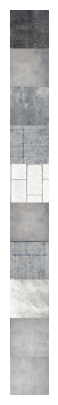

Number of non-crack images: 8404
Number of crack images: 8404
Epoch 1/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 172s 404ms/step - accuracy: 0.7194 - loss: 7.2970 - val_accuracy: 0.8322 - val_loss: 0.1048
Epoch 2/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 165s 391ms/step - accuracy: 0.8632 - loss: 0.0860 - val_accuracy: 0.9311 - val_loss: 0.0478
Epoch 3/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 162s 386ms/step - accuracy: 0.9119 - loss: 0.0576 - val_accuracy: 0.9560 - val_loss: 0.0343
Epoch 4/10
421/421 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9377 - loss: 0.0463

KeyboardInterrupt: 

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

''' the augmentaing part '''
dataset.augment()
dataset = CrackSegmentationDataset()
counter = Counter(instance.get_label() for instance in dataset.train_instances)
# the augmentation of the data
print(f"Number of non-crack images: {counter[0]}")
print(f"Number of crack images: {counter[1]}")

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=32, task='classification')

# Build simple binary classification model
classification_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(448, 448, 3)),  # Define fixed input shape
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification
])

classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)

# Train classification model
classification_model.fit(
    train_ds,
    validation_data=val_ds,  # Pass validation data here
    epochs=10,
    callbacks=[epoch_early_stopping],  # Use epoch-wise early stopping
     # Use batch-wise early stopping callback
    verbose=1  # Print logs
)

In [ ]:
# Evaluate the model on the test dataset
test_ds, _ = dataset.get_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.9167 - loss: 0.0727
Test Loss: 0.0664
Test Accuracy: 0.9180
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.63      0.82      0.71       212
       Crack       0.97      0.93      0.95      1483

    accuracy                           0.92      1695
   macro avg       0.80      0.88      0.83      1695
weighted avg       0.93      0.92      0.92      1695

Confusion Matrix:
[[ 174   38]
 [ 101 1382]]


### conclusions
surprisingly the augmentation of data did not bring the improvement in the accuracy or f1 scores for both classes, it seems it has overfitted to the training set as it was receiving very high accuracy there - and worse on validation and training. As expected it increased the recall of the non-crack class, but on the other hand decreased it's precision , overall the model not utilizing the data augmentation proved to perform better on the test set.

### Unet model
here are defined the unet and unet++ which will be mainly used for the segmentation but we may also try using it for classification


In [12]:
'''with the batch normalization'''
def unet_model(input_shape,filter_number=32,segmentation=True):
    inputs = Input(shape=input_shape)

    # Layer converting the picture into grayscale
    lambda_layer = Lambda(lambda x: (0.21 * x[..., :1]) + (0.72 * x[..., 1:2]) + (0.07 * x[..., -1:]))(inputs)

    # Encoder phase, downsampling of the picture
    d1 = Conv2D(filter_number, (3, 3), padding='same')(lambda_layer)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    d1 = Conv2D(filter_number, (3, 3), padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    p1 = MaxPooling2D((2, 2))(d1)

    d2 = Conv2D(filter_number*2, (3, 3), padding='same')(p1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    d2 = Conv2D(filter_number*2, (3, 3), padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    p2 = MaxPooling2D((2, 2))(d2)

    d3 = Conv2D(filter_number*4, (3, 3), padding='same')(p2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Conv2D(filter_number*4, (3, 3), padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    p3 = MaxPooling2D((2, 2))(d3)

    d4 = Conv2D(filter_number*8, (3, 3), padding='same')(p3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Conv2D(filter_number*8, (3, 3), padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)

    # Bottleneck
    b = MaxPooling2D((2, 2))(d4)
    b = Conv2D(filter_number*16, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)
    b = Conv2D(filter_number*16, (3, 3), padding='same')(b)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder phase, upsampling of the picture
    u1 = Conv2DTranspose(filter_number*8, (2, 2), strides=(2, 2), padding='same')(b)
    u1 = concatenate([u1, d4])  # Skip connection
    u1 = Conv2D(filter_number*8, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)
    u1 = Conv2D(filter_number*8, (3, 3), padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = Activation('relu')(u1)

    u2 = Conv2DTranspose(filter_number*4, (2, 2), strides=(2, 2), padding='same')(u1)
    u2 = concatenate([u2, d3])  # Skip connection
    u2 = Conv2D(filter_number*4, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)
    u2 = Conv2D(filter_number*4, (3, 3), padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = Activation('relu')(u2)

    u3 = Conv2DTranspose(filter_number*2, (2, 2), strides=(2, 2), padding='same')(u2)
    u3 = concatenate([u3, d2])  # Skip connection
    u3 = Conv2D(filter_number*2, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)
    u3 = Conv2D(filter_number*2, (3, 3), padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = Activation('relu')(u3)

    u4 = Conv2DTranspose(filter_number, (2, 2), strides=(2, 2), padding='same')(u3)
    u4 = concatenate([u4, d1])  # Skip connection
    u4 = Conv2D(filter_number, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)
    u4 = Conv2D(filter_number, (3, 3), padding='same')(u4)
    u4 = BatchNormalization()(u4)
    u4 = Activation('relu')(u4)

    if not segmentation:
      gap = GlobalAveragePooling2D()(u4)  # This layer reduces the spatial dimensions (height, width) to a scalar

    # Fully connected layer with sigmoid to predict binary output (crack or no crack)
      output = tf.keras.layers.Dense(1, activation='sigmoid')(gap)  # A single output for the whole image, with a sigmoid activation
      model = tf.keras.Model(inputs=[inputs], outputs=[output])
      return model

    #output layer, sigmoid to map the likelhood of belonging to given class
    else:
      outputs = Conv2D(1, (1, 1), activation='sigmoid')(u4)
      #outputs = Conv2D(2, (1, 1), activation='softmax')(c9)

      #the finaly binray image , iff  mapping , belonging to which class was bigger
      model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
      return model

mod = unet_model(input_shape=(448, 448, 3),filter_number=16,segmentation=True)
mod.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 448, 448, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 448, 448, 1)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 448, 448, 16)   │            160 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 448, 448, 16)   │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 448, 448, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 448, 448, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 448, 448, 16)   │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 448, 448, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 224, 224, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 224, 224, 32)   │          4,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 32)   │            128 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 224, 224, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224, 224, 32)   │            128 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 224, 224, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 112, 112, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 1,946,705 (7.43 MB)

 Trainable params: 1,943,761 (7.41 MB)

 Non-trainable params: 2,944 (11.50 KB)

### Unet++ model

In [ ]:
def unet_plus_plus(input_shape,filter_number=32, deep_supervision=False):
    inputs = Input(shape=input_shape)

    # Layer converting the picture into grayscale
    lambda_layer = Lambda(lambda x: (0.21 * x[..., :1]) + (0.72 * x[..., 1:2]) + (0.07 * x[..., -1:]))(inputs)

    # Encoder phase, downsampling of the picture
    d1 = Conv2D(filter_number, (3, 3), padding='same')(lambda_layer)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    d1 = Conv2D(filter_number, (3, 3), padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Activation('relu')(d1)
    p1 = MaxPooling2D((2, 2))(d1)

    d2 = Conv2D(2*filter_number, (3, 3), padding='same')(p1)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    d2 = Conv2D(2*filter_number, (3, 3), padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Activation('relu')(d2)
    p2 = MaxPooling2D((2, 2))(d2)

    d3 = Conv2D(4*filter_number, (3, 3), padding='same')(p2)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    d3 = Conv2D(4*filter_number, (3, 3), padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Activation('relu')(d3)
    p3 = MaxPooling2D((2, 2))(d3)

    d4 = Conv2D(8*filter_number, (3, 3), padding='same')(p3)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    d4 = Conv2D(8*filter_number, (3, 3), padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Activation('relu')(d4)
    p4 = MaxPooling2D((2, 2))(d4)

    d5 = Conv2D(16*filter_number, (3, 3), padding='same')(p4)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)
    d5 = Conv2D(16*filter_number, (3, 3), padding='same')(d5)
    d5 = BatchNormalization()(d5)
    d5 = Activation('relu')(d5)

    # Decoder phase with Batch Normalization and deep supervision
    def decoder_block(up_input, skip_input, filters):
        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(up_input)
        up = concatenate([up, skip_input])
        up = Conv2D(filters, (3, 3), padding='same')(up)
        up = BatchNormalization()(up)
        up = Activation('relu')(up)
        up = Conv2D(filters, (3, 3), padding='same')(up)
        up = BatchNormalization()(up)
        up = Activation('relu')(up)
        return up

    u_01 = decoder_block(d2, d1, filter_number)
    u_11 = decoder_block(d3, d2, filter_number*2)
    u_21 = decoder_block(d4, d3, filter_number*4)
    u_31 = decoder_block(d5, d4, filter_number*8)

    u_02 = decoder_block(u_11, u_01, filter_number)
    u_12 = decoder_block(u_21, u_11, filter_number*2)
    u_22 = decoder_block(u_31, u_21, filter_number*4)

    u_03 = decoder_block(u_12, u_02, filter_number)
    u_13 = decoder_block(u_22, u_12, filter_number*2)

    u_04 = decoder_block(u_13, u_03, filter_number)

    if deep_supervision:
        outputs = [
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_01)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_02)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_03)),
            Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(
                tf.keras.layers.Conv2D(2, (1, 1), activation='sigmoid')(u_04))
        ]
        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
        return model

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u_04)
    # binary_outputs = Lambda(lambda x: tf.cast(tf.greater(x[..., 1], x[..., 0]), tf.float32))(outputs)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


### The unet model for classification

usually the unet model is used for the semantic segmentation, but maybe we can try utylizing it for the purpose of classification.

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=8, task='classification')

# Build simple binary classification model
classification_model = unet_model(input_shape=(448, 448, 3),filter_number=16,segmentation=False)
classification_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryFocalCrossentropy(
    apply_class_balancing=False,
    alpha=0.25,
    gamma=2.0,
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_focal_crossentropy'
),
    metrics=['accuracy']
)

classification_model.fit(
    train_ds,
    validation_data=val_ds,  # Pass validation data here
    epochs=10,
    callbacks=[epoch_early_stopping],  # Use epoch-wise early stopping
     # Use batch-wise early stopping callback
    verbose=1  # Print logs
)

NameError: name 'unet_model' is not defined

In [ ]:
# Evaluate the model on the test dataset
test_ds, _ = dataset.get_test_dataset(split='test', batch_size=32, task='classification')
loss, accuracy = classification_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Compute additional metrics
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = classification_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Non-Crack", "Crack"]))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

53/53 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.9257 - loss: 0.0277
Test Loss: 0.0301
Test Accuracy: 0.9198
Classification Report:
              precision    recall  f1-score   support

   Non-Crack       0.70      0.62      0.66       212
       Crack       0.95      0.96      0.95      1483

    accuracy                           0.92      1695
   macro avg       0.83      0.79      0.81      1695
weighted avg       0.92      0.92      0.92      1695

Confusion Matrix:
[[ 131   81]
 [  55 1428]]


### conclusions

It didnt perform bad, but it was worse than the  earlier simpler model, likely because it is not the perfect architecture for classification

# Semantic segmentation -Todo
Here the semantic segmentation will take place, firstly we will try the unet model and une++ models trained from scratch .



### TODO
-trying out these loss functions, thinking/trying the parameters in the focal loss function - alpha parameter, which determines which mistake to penalize more - predicting crack when there is no crack , or predicting no crack when there is crack. probably the predicting non crack when there is crack should be penalized much more , since model tends to predict non crack everywhere, and there is much more non crack pixels
- trying different batch sizes, 1 probably to small , 32 the ram may not be able to fit but maybe it will be ok also , but maybe something between these number
- Determining the number of epochs, probably on defualt many epochs can be set, but with early stopping to prevent the overfitting in some cases
- trying different channel number for the unet architecture: filter_channel argument in the unet model creation function. In the original implementation it is 64, but probably lesser power of 2 can be tried for more efficent, less memory expeensive approach
#### Later on
- when achieveed some decent score, we may try to extract ground truths and predictions for visulization, for example 10 with the smalles loss for the non crack class and for the crack class, and 10 worse predictions , one with biggest loss, for both crack and non crack


- Jedrzej: I will try to run with different parameters and see what the outcomes are , but i think we can do it both, and we can check if it yields some decent result. If not we can think of changing the looose function, or even architecture.

#### Loss functions for the semantic segmentation

In [13]:
def dice_loss(smooth=1):
    def dice_loss_fixed(y_true, y_pred):
        # Ensure tensors are in the same shape
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        # Flatten the tensors
        y_true_f = tf.reshape(y_true, [-1])  # Flatten to 1D
        y_pred_f = tf.reshape(y_pred, [-1])  # Flatten to 1D

        # Compute the intersection
        intersection = tf.reduce_sum(y_true_f * y_pred_f)

        # Compute Dice coefficient
        dice_coeff = (2. * intersection + smooth) / (
            tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
        )

        # Return Dice loss (1 - Dice coefficient)
        return 1 - dice_coeff
    return dice_loss_fixed

def focal_loss(gamma=2., alpha=0.95):
  # alpha = class balancing parameter,
  #gamma - penalizing more the bigger mistakes
  # adressing the class imbalance , which is defnitely a case in the crack detection, there are much less crack pixels than non crack pixels.
    def focal_loss_fixed(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        pt_1 = tf.where(K.equal(y_true, 1), y_pred, K.ones_like(y_pred))
        pt_0 = tf.where(K.equal(y_true, 0), 1 - y_pred, K.ones_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.sum((1 - alpha) * K.pow(1. - pt_0, gamma) * K.log(pt_0))
    return focal_loss_fixed
def combined_dice_focal_loss(y_true, y_pred):
    dice = dice_loss(y_true, y_pred)
    focal = focal_loss()(y_true, y_pred)
    return 0.5 * dice + 0.5 * focal

'''usefull metrics defined to determine the semantic segmentation performance of network '''
def crack_precision(y_true, y_pred):
    # Apply a threshold to y_pred (sigmoid output) to convert probabilities to binary (0 or 1)
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())  # Threshold at 0.5

    # Calculate True Positives and False Positives
    TP = K.sum(y_true * y_pred_bin)
    FP = K.sum((1 - y_true) * y_pred_bin)

    # Avoid division by zero (e.g., when no positive class is predicted)
    precision = TP / (TP + FP + K.epsilon())
    return precision

def crack_recall(y_true, y_pred):
    # Apply a threshold to y_pred (sigmoid output) to convert probabilities to binary (0 or 1)
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())  # Threshold at 0.5

    # Calculate True Positives and False Negatives
    TP = K.sum(y_true * y_pred_bin)
    FN = K.sum(y_true * (1 - y_pred_bin))

    # Avoid division by zero (e.g., when no positive class exists in the true labels)
    recall = TP / (TP + FN + K.epsilon())
    return recall

def non_crack_recall(y_true, y_pred):
    # Apply a threshold to y_pred (sigmoid output) to convert probabilities to binary (0 or 1)
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())  # Threshold at 0.5

    # Calculate True Negatives (TN) and False Positives (FP) for class 0
    TN = K.sum((1 - y_true) * (1 - y_pred_bin))  # True Negatives
    FP = K.sum((1-y_true) * y_pred_bin)        # False Positives

    # Avoid division by zero (e.g., when no non-crack class exists in the true labels)
    recall = TN / (TN + FP + K.epsilon())  # Recall formula for class 0
    return recall

def non_crack_precision(y_true, y_pred):
    # Apply a threshold to y_pred (sigmoid output) to convert probabilities to binary (0 or 1)
    y_pred_bin = K.cast(K.greater(y_pred, 0.5), K.floatx())  # Threshold at 0.5

    # Calculate True Negatives (TN) and False Negatives (FN) for class 0
    TN = K.sum((1 - y_true) * (1 - y_pred_bin))  # True Negatives
    FN = K.sum(y_true * (1-y_pred_bin))        # False Negatives

    # Avoid division by zero (e.g., when no non-crack class exists in the true labels)
    precision = TN / (TN + FN + K.epsilon())  # Precision formula for class 0
    return precision

### Testing the unet semantic segmentation

firstly we will check the different loss functions on the data, we will start off with the mini batch- of 1 item, since it is quite memory efficent and also since in this case  gradients are derived from every single image, they are noisier. This noise can prevent overfitting to some extent, as it helps the model escape sharp minima in the loss landscape working a bit like stochastic gradient descent.
but it can take longer to converge and be very unstable

In [14]:
epoch_early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=1, task='segmentation',stratified=False)

segmentation_model = unet_model(input_shape=(448, 448, 3),filter_number=4,segmentation='True')
segmentation_model.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=[crack_precision, crack_recall,non_crack_precision,non_crack_recall]
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
   7679/Unknown 141s 15ms/step - crack_precision: 0.2140 - crack_recall: 0.6977 - loss: 1449.2589 - non_crack_precision: 0.9907 - non_crack_recall: 0.8897

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


7682/7682 ━━━━━━━━━━━━━━━━━━━━ 158s 17ms/step - crack_precision: 0.2140 - crack_recall: 0.6977 - loss: 1449.1573 - non_crack_precision: 0.9907 - non_crack_recall: 0.8897 - val_crack_precision: 0.2183 - val_crack_recall: 0.6919 - val_loss: 2241.4104 - val_non_crack_precision: 0.9907 - val_non_crack_recall: 0.7166
Epoch 2/10
2197/7682 ━━━━━━━━━━━━━━━━━━━━ 1:20 15ms/step - crack_precision: 0.2947 - crack_recall: 0.7837 - loss: 1004.4420 - non_crack_precision: 0.9946 - non_crack_recall: 0.9235

KeyboardInterrupt: 

In [16]:
test_ds, _ = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall, non_crack_precision, non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test crack Precision: {crack_precision:.4f}")
print(f"Test crack Recall: {crack_recall:.4f}")
print(f"Test non-crack Precision: {non_crack_precision:.4f}")
print(f"Test non-crack Recall: {non_crack_recall:.4f}")

1695/1695 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - crack_precision: 0.2903 - crack_recall: 0.5214 - loss: 2136.6626 - non_crack_precision: 0.9779 - non_crack_recall: 0.8548
Test Loss: 2098.8083
Test crack Precision: 0.2815
Test crack Recall: 0.5282
Test non-crack Precision: 0.9770
Test non-crack Recall: 0.8534


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


### batch size adjustment

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=8, task='segmentation', stratified=True)

segmentation_model = unet_model(input_shape=(448, 448, 3),filter_number=32)
segmentation_model.compile(
    optimizer='adam',
    loss=focal_loss(),
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

Epoch 1/10
    243/Unknown 196s 521ms/step - accuracy: 0.8579 - loss: 15911.2646

In [ ]:
test_ds, _ = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall, non_crack_precision, non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test crack Precision: {crack_precision:.4f}")
print(f"Test crack Recall: {crack_recall:.4f}")
print(f"Test non-crack Precision: {non_crack_precision:.4f}")
print(f"Test non-crack Recall: {non_crack_recall:.4f}")

ValueError: Cannot take the length of shape with unknown rank.

### other loss functions on the unet model with bigger batch size

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)

train_ds, val_ds = dataset.get_dataset(split='train', batch_size=8, task='segmentation',stratified=True)

segmentation_model = unet_model(input_shape=(448, 448, 3),filter_number=32)
segmentation_model.compile(
    optimizer='adam',
    loss=dice_loss(),
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

In [ ]:
test_ds, _ = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall,non_crack_precision,non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"test crack Precision: {crack_precision:.4f}")
print(f"testc crack Recall: {crack_recall:.4f}")
print(f"test non-crack Precision: {non_crack_precision:.4f}")
print(f"testc non-crack Recall: {non_crack_recall:.4f}")

In [ ]:
epoch_early_stopping = EarlyStopping(
    monitor='val_accuracy',       # Monitor validation loss
    patience=3,               # Stop training if no improvement for 5 epochs
    restore_best_weights=True # Restore the best weights on stopping
)


train_ds, val_ds = dataset.get_dataset(split='train', batch_size=8, task='segmentation',stratified=True)

segmentation_model = unet_model(input_shape=(448, 448, 3), filter_number=32)
segmentation_model.compile(
    optimizer='adam',
    loss=combined_dice_focal_loss(),
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=val_ds,callbacks=[epoch_early_stopping], epochs=10)

In [ ]:
test_ds, _ = dataset.get_dataset(split='test', batch_size=1, task='segmentation')
loss, crack_precision, crack_recall,non_crack_precision,non_crack_recall = segmentation_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"test crack Precision: {crack_precision:.4f}")
print(f"testc crack Recall: {crack_recall:.4f}")
print(f"test non-crack Precision: {non_crack_precision:.4f}")
print(f"testc non-crack Recall: {non_crack_recall:.4f}")

### Unet++ model for semantic segmentation of cracks
this is an adjusted  version of the unet architecture which  allows not only for the skip connections between the encoder and decoder  layer on the respective level but also for connections between the decoder and all the encoder below - on deeper level



In [ ]:
train_ds = dataset.get_dataset(split='train', batch_size=32, task='segmentation')
test_ds = dataset.get_dataset(split='test', batch_size=32, task='segmentation')
segmentation_model = unet_plus_plus(input_shape=(448, 448, 3),filter_number=16)
segmentation_model.compile(
    optimizer='adam',
    loss='focal_loss',
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=test_ds, epochs=10)

In [ ]:
train_ds = dataset.get_dataset(split='train', batch_size=32, task='segmentation')
test_ds = dataset.get_dataset(split='test', batch_size=32, task='segmentation')
segmentation_model = unet_plus_plus(input_shape=(448, 448, 3),filter_number=16)
segmentation_model.compile(
    optimizer='adam',
    loss='dice_loss',
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=test_ds, epochs=10)

In [ ]:
train_ds = dataset.get_dataset(split='train', batch_size=32, task='segmentation')
test_ds = dataset.get_dataset(split='test', batch_size=32, task='segmentation')
segmentation_model = unet_plus_plus(input_shape=(448, 448, 3),filter_number=16)
segmentation_model.compile(
    optimizer='adam',
    loss='combined_dice_focal_loss',
    metrics=['accuracy']
)
segmentation_model.fit(train_ds, validation_data=test_ds, epochs=10)